# N05B. Selección oferta
Con base en la proyección de precios de bolsa mensuales (Pbm) para tres escenarios, se realizará la selección de la mejor oferta.

(Para convertir a docx: pandoc N05_SeleccionOferta.ipynb -s -o N04.docx).


## 5.1. Ofertas presentadas 
Se presentaron 7 ofertas:

1. Cuatro con la modalidad M2, de precio atado al Precio de Bolsa Horario.
2. Una con la modalidad M1 de precio fijo.
3. Una modalidad M4, con la combinación por porcentajes de precio fijo (80%) y Precio de Bolsa Horario (20%).
4. Una modalidad M5, con la combinación por cantidades de energía de precio fijo (hasta 8 GWh) y Precio de Bolsa Horario (por encima de 8 GWh).

Las ofertas M2 y M5 de DICEL se integraron en una sola, ya que se complementan en los diferentes periodos.

In [2]:
#*******************************************************************************       
# 5.1.1. Carga paquetes requeridos para realizar la selección.
#*******************************************************************************
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#*******************************************************************************       
# 5.1.2. Crea la estructura de las ofertas.
#*******************************************************************************
ofertas = pd.DataFrame({'nombre_oferta': ['ENEL_M2', 'AIRE_M2', 'DICEL_M2_M5', \
    'EMSA_M2', 'AIRE_M1', 'AIRE_M4'], 'periodos': ['P1:P7', \
        'P1:P7', 'P1:P7', 'P1:P2', 'P1:P7', 'P1:P7'], 'cargoC_pbh': [8.90, \
        13.00, 16.00, 18.00, None, None], 'precioFijo': [None, \
        None, 294.00, None, 280.20, 280.20], 'porcentajePFijo': [None, \
        None, 'Hasta 8 GWh', None, '100%', 'Hasta 80%'], 'comentario': ['C se ajusta con IPP', \
        'C se ajusta con IPP', 'Se integra M2 y M5', \
            'C se ajusta con IPP', 'PFijo cambia por periodo', \
                'PFijo cambia por periodo']}, index=range(1, 7))
ofertas

,nombre_oferta,periodos,cargoC_pbh,precioFijo,porcentajePFijo,comentario
1,ENEL_M2,P1:P7,8.9,NaN,None,C se ajusta con IPP
2,AIRE_M2,P1:P7,13.0,NaN,None,C se ajusta con IPP
3,DICEL_M2_M5,P1:P7,16.0,294.0,Hasta 8 GWh,Se integra M2 y M5
4,EMSA_M2,P1:P2,18.0,NaN,None,C se ajusta con IPP
5,AIRE_M1,P1:P7,NaN,280.2,100%,PFijo cambia por periodo
6,AIRE_M4,P1:P7,NaN,280.2,Hasta 80%,PFijo cambia por periodo


In [4]:
#*******************************************************************************       
# 5.1.3. Se crea estructura de vpn_ofertas y vpn_ofertas_p1p2 (Em Millones de COP).
#*******************************************************************************
vpn_ofertas = pd.DataFrame({'Escenario Alto': np.NaN, \
        'Escenario Medio': np.NaN, 'Escenario Bajo': np.NaN}, index=['ENEL_M2', 'AIRE_M2', 'DICEL_M2_M5', \
    'EMSA_M2', 'AIRE_M1', 'AIRE_M4'])
vpn_ofertas_p1p2 = pd.DataFrame({'Escenario Alto': np.NaN, \
        'Escenario Medio': np.NaN, 'Escenario Bajo': np.NaN}, index=['ENEL_M2', 'AIRE_M2', 'DICEL_M2_M5', \
    'EMSA_M2', 'AIRE_M1', 'AIRE_M4'])
vpn_ofertas

,Escenario Alto,Escenario Medio,Escenario Bajo
ENEL_M2,NaN,NaN,NaN
AIRE_M2,NaN,NaN,NaN
DICEL_M2_M5,NaN,NaN,NaN
EMSA_M2,NaN,NaN,NaN
AIRE_M1,NaN,NaN,NaN
AIRE_M4,NaN,NaN,NaN


## 5.2. Demanda de energía mensual
En el análisis se tomará como base la demanda mensual proyectada por Cepsa. El primer mes es diciembre de 2022 y el último mes es diciembre de 2028.

In [5]:
#*******************************************************************************       
# 5.2.1. Lee la 'demanda' proyetada del bloque.
#*******************************************************************************
#Lee demanda
demanda = pd.read_parquet('parquet/demanda.parquet.gzip', \
    engine='fastparquet')

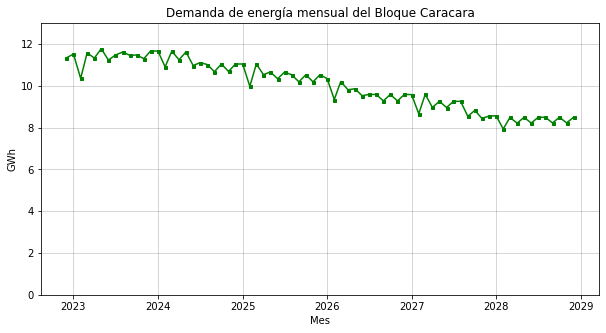

In [49]:
#*******************************************************************************
# 5.2.2. Grafica de demanda.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Demanda de energía mensual del Bloque Caracara')
ax1.set_ylabel ('GWh')
ax1.set_xlabel ('Mes')
ax1.plot(demanda.index, demanda.demanda, 'g-s', \
    label='Demanda', markersize=3)
# plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 13)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 5.3. Proyección de precios de bolsa mensual
El análisis se realizará asumiendo tres escenarios de precios de energía de bolsa mensuales, que fueron elaborados previamente y cuya metodología de cálculo se muestra en un documento complementario.

In [8]:
#*******************************************************************************       
# 5.3.1. Se leen las proyecciones de pbm, pbm_py_f. Calculadas previamente.
#*******************************************************************************
#Lee pbm_py
pbm_py_f = pd.read_parquet\
    ('parquet/pbm_py_f.parquet.gzip', engine='fastparquet')

In [9]:
#*******************************************************************************       
# 5.3.2. Se ajustan columnas y fechas.
#*******************************************************************************
pbm_py_f = pbm_py_f.drop(columns=['pbm'], axis=1)
pbm_py_f = pbm_py_f.loc[pd.to_datetime('2022-12-01'):pd.to_datetime('2028-12-01'), :]

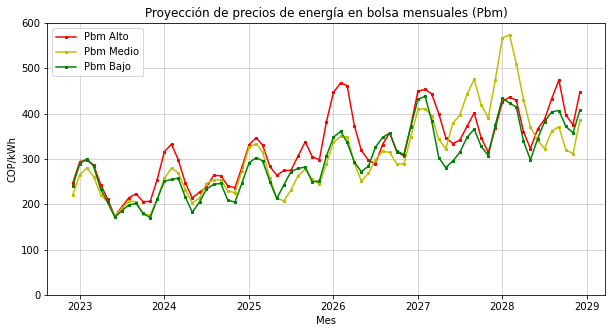

In [10]:
#*******************************************************************************
# 5.3.3. Grafica de proyección de precios de energía en bolsa mensuales.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Proyección de precios de energía en bolsa mensuales (Pbm)')
ax1.set_ylabel ('COP/kWh')
ax1.set_xlabel ('Mes')
ax1.plot(pbm_py_f.index, pbm_py_f.pbm_alto, 'r-s', \
    label='Pbm Alto', markersize=2)
ax1.plot(pbm_py_f.index, pbm_py_f.pbm_medio, 'y-s', \
    label='Pbm Medio', markersize=2)
ax1.plot(pbm_py_f.index, pbm_py_f.pbm_bajo, 'g-s', \
    label='Pbm Bajo', markersize=2)
plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 600)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 5.4. Proyección del IPP
Para poder calcular los precios futuros, que permiten estimar los egresos de energía, se debe realizar una proyección del IPP, ya que los componentes de los precios de las ofertas (cargo C de comercialización y el precio fijo) están expresados en pesos de abril de 2022. Estos precios se deben ajustar mensualmente.

In [11]:
#*******************************************************************************       
# 5.4.1. Lee el ipp_py (proyectado).
#*******************************************************************************
#Lee ipp_py
ipp_py = pd.read_parquet\
    ('parquet/ipp_py.parquet.gzip', engine='fastparquet')
ipp_28 = ipp_py.loc[pd.to_datetime('2022-12-01'): pd.to_datetime('2028-12-01'), 'proyeccion28']
ipp_28.name = 'ipp'

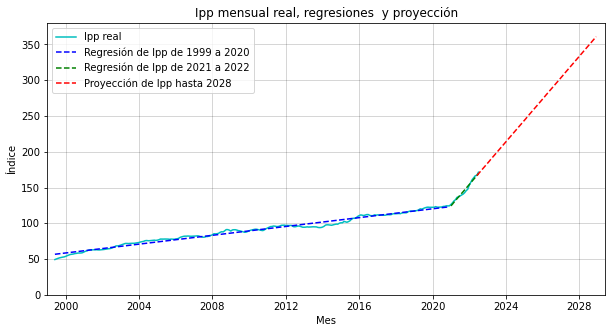

In [12]:
#*******************************************************************************
# 5.4.2. Grafica el IPP.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Ipp mensual real, regresiones  y proyección')
ax1.set_ylabel ('Índice')
ax1.set_xlabel ('Mes')
ax1.plot(ipp_py.index, ipp_py.ipp, 'c-', \
    label='Ipp real', markersize=2)
ax1.plot(ipp_py.index, ipp_py.regresion99, 'b--', \
    label='Regresión de Ipp de 1999 a 2020', markersize=2)
ax1.plot(ipp_py.index, ipp_py.regresion21, 'g--', \
    label='Regresión de Ipp de 2021 a 2022', markersize=2)
ax1.plot(ipp_py.index, ipp_py.proyeccion28, 'r--', \
    label='Proyección de Ipp hasta 2028', markersize=2)
plt.legend(loc='best')
plt.xlim(pd.to_datetime('1999-01-01'), pd.to_datetime('2029-06-01'))
plt.ylim(0, 380)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 5.5. Factor de descuento
Para poder calcular el VPN de los egresos por compra de energía se requiere calcular el factor de descuento mensual. Inicialmente se asumirá una tasa de descuento anual del 10%, equivalente al 0,79% mensual.

In [14]:
#*******************************************************************************       
# 5.5.1. Factor de descuento de los egresos. Tasa 10% anual.
#*******************************************************************************
tasa_descuento_anual = 0.1 #10% anual.
tasa_descuento_mensual = ((1 + tasa_descuento_anual) ** (1/12)) - 1
tasa_descuento_mensual #tasa_descuento_mensual = 0,79%.
factor_descuento = pd.DataFrame({'n_mes':range(0, 73)}, \
        index=pd.date_range(start="2022-12-01",end="2028-12-01", freq='MS'))
factor_descuento.insert(loc=len(factor_descuento.columns), \
        column='factor_descuento', value=(1 / (1 + tasa_descuento_mensual) ** \
                factor_descuento.n_mes), allow_duplicates=True)
factor_descuento = factor_descuento.drop(columns='n_mes', axis=1)

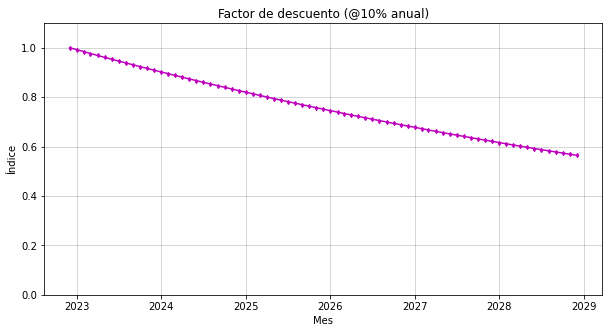

In [15]:
#*******************************************************************************
# 5.5.2. Grafica de factor de descuento.
#*******************************************************************************
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(1, 1, 1)  # Crea una figura conteniendo un solo eje.
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, \
    wspace=None, hspace=None)
ax1.set_title ('Factor de descuento (@10% anual)')
ax1.set_ylabel ('Índice')
ax1.set_xlabel ('Mes')
ax1.plot(factor_descuento.index, factor_descuento.factor_descuento, 'm-d', \
    label='Factor de descuento', markersize=3)
# plt.legend(loc='best')
# plt.xlim(pd.to_datetime('2018-01-01'), pd.to_datetime('2022-07-01'))
plt.ylim(0, 1.1)
plt.grid(axis='both', color='k', alpha=0.2)
plt.show()

## 5.5. Egresos de las ofertas
La comparación de las ofertas se realizará con base en el VPN de los egresos de los cargos No Regulados, es decir los componentes de Generación (G) más Comercialización (C). Una vez se seleccione la mejor oferta y con el fin de estimar el presupuesto de los egresos por compra de energía, a la oferta seleccionada se le adicionarán los componentes de los cargos Regulados. Los componentes Regulados son iguales para todas las ofertas.

### 5.5.1. Egreso de la oferta ENEL_M2
Con esta propuesta ENEL ofertó para todos los periodos, bajo la modalidad de Precio de Bolsa Horario más un cargo de Comercialización de 8,90 COP/kWh. Este precio está expresado en pesos de abril de 2022 y se debe indexar mensualmente con el IPP. 

In [17]:
#*******************************************************************************       
# 5.5.1.1. Se calcula egreso.
#*******************************************************************************
egreso_ENEL_M2 = pd.concat([demanda, pbm_py_f, ipp_28, factor_descuento], \
    axis=1)
ipp_202204 = ipp_py.loc[pd.to_datetime('2022-04-01'), 'ipp']
comer0 = 8.9 #Oferta de ENEL_M2 para abril de 2022.
#*************************
#Ajusta el cargo de comercialización con el IPP.
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='comer', \
    value=egreso_ENEL_M2.ipp * comer0/ipp_202204, allow_duplicates=True )
#*************************
#Calcula el precio (COP/kWh) de energía en los tres escenarios (G+C).
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='precio_alto', \
    value=egreso_ENEL_M2.pbm_alto + egreso_ENEL_M2.comer, allow_duplicates=True )
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='precio_medio', \
    value=egreso_ENEL_M2.pbm_medio + egreso_ENEL_M2.comer, allow_duplicates=True )
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='precio_bajo', \
    value=egreso_ENEL_M2.pbm_bajo + egreso_ENEL_M2.comer, allow_duplicates=True )
#*************************
#Calcula el egreso de energía (G+C) en los tres escenarios (Millones de COP).
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='egreso_alto', \
    value=egreso_ENEL_M2.precio_alto * egreso_ENEL_M2.demanda, allow_duplicates=True )
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='egreso_medio', \
    value=egreso_ENEL_M2.precio_medio * egreso_ENEL_M2.demanda, allow_duplicates=True )
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='egreso_bajo', \
    value=egreso_ENEL_M2.precio_bajo * egreso_ENEL_M2.demanda, allow_duplicates=True )
#*************************
#Calcula el egreso de energía descontado en los tres escenarios (Millones de COP).
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='egreso_alto_d', \
    value=egreso_ENEL_M2.egreso_alto * egreso_ENEL_M2.factor_descuento, \
        allow_duplicates=True )
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='egreso_medio_d', \
    value=egreso_ENEL_M2.egreso_medio * egreso_ENEL_M2.factor_descuento, \
        allow_duplicates=True )
egreso_ENEL_M2.insert(loc=len(egreso_ENEL_M2.columns), column='egreso_bajo_d', \
    value=egreso_ENEL_M2.egreso_bajo * egreso_ENEL_M2.factor_descuento, \
        allow_duplicates=True )
#*************************
#Carga el VPN de egresos en los tres escenarios en la estructura vpn_ofertas.
vpn_ofertas.loc['ENEL_M2', 'Escenario Alto'] = \
    egreso_ENEL_M2.egreso_alto_d.sum()
vpn_ofertas.loc['ENEL_M2', 'Escenario Medio'] = \
    egreso_ENEL_M2.egreso_medio_d.sum()
vpn_ofertas.loc['ENEL_M2', 'Escenario Bajo'] = \
    egreso_ENEL_M2.egreso_bajo_d.sum()
# #*************************
#Carga el VPN de egresos en los tres escenarios en vpn_ofertas_p1p2.
vpn_ofertas_p1p2.loc['ENEL_M2', 'Escenario Alto'] = \
    egreso_ENEL_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto_d'].sum()
vpn_ofertas_p1p2.loc['ENEL_M2', 'Escenario Medio'] = \
    egreso_ENEL_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio_d'].sum()
vpn_ofertas_p1p2.loc['ENEL_M2', 'Escenario Bajo'] = \
    egreso_ENEL_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo_d'].sum()

In [18]:
#*******************************************************************************       
# 5.5.1.2. Salva egreso_ENEL_M2.
#*******************************************************************************
# # #Salva egreso_ENEL_M2
# egreso_ENEL_M2.to_parquet('parquet/egreso_ENEL_M2.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
# egreso_ENEL_M2.to_excel('xlsx/egreso_ENEL_M2.xlsx', sheet_name='hoja_1')
#Lee egreso_ENEL_M2
egreso_ENEL_M2 = pd.read_parquet('parquet/egreso_ENEL_M2.parquet.gzip', \
    engine='fastparquet')

### 5.5.2. Egreso de la oferta AIRE_M2
Con esta propuesta AIRE ofertó para todos los periodos, bajo la modalidad de Precio de Bolsa Horario más un cargo de Comercialización de 13,00 COP/kWh. Este precio está expresado en pesos de abril de 2022 y se debe indexar mensualmente con el IPP. 

In [19]:
#*******************************************************************************       
# 5.5.2.1. Se calcula egreso.
#*******************************************************************************
egreso_AIRE_M2 = pd.concat([demanda, pbm_py_f, ipp_28, factor_descuento], \
    axis=1)
ipp_202204 = ipp_py.loc[pd.to_datetime('2022-04-01'), 'ipp']
comer0 = 13.00 #Oferta de AIRE_M2 para abril de 2022.
#*************************
#Ajusta el cargo de comercialización con el IPP.
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='comer', \
    value=egreso_AIRE_M2.ipp * comer0/ipp_202204, allow_duplicates=True )
#*************************
#Calcula el precio (COP/kWh) de energía en los tres escenarios (G+C).
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='precio_alto', \
    value=egreso_AIRE_M2.pbm_alto + egreso_AIRE_M2.comer, allow_duplicates=True )
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='precio_medio', \
    value=egreso_AIRE_M2.pbm_medio + egreso_AIRE_M2.comer, allow_duplicates=True )
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='precio_bajo', \
    value=egreso_AIRE_M2.pbm_bajo + egreso_AIRE_M2.comer, allow_duplicates=True )
#*************************
#Calcula el egreso de energía (G+C) en los tres escenarios (Millones de COP).
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='egreso_alto', \
    value=egreso_AIRE_M2.precio_alto * egreso_AIRE_M2.demanda, allow_duplicates=True )
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='egreso_medio', \
    value=egreso_AIRE_M2.precio_medio * egreso_AIRE_M2.demanda, allow_duplicates=True )
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='egreso_bajo', \
    value=egreso_AIRE_M2.precio_bajo * egreso_AIRE_M2.demanda, allow_duplicates=True )
#*************************
#Calcula el egreso de energía descontado en los tres escenarios (Millones de COP).
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='egreso_alto_d', \
    value=egreso_AIRE_M2.egreso_alto * egreso_AIRE_M2.factor_descuento, \
        allow_duplicates=True )
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='egreso_medio_d', \
    value=egreso_AIRE_M2.egreso_medio * egreso_AIRE_M2.factor_descuento, \
        allow_duplicates=True )
egreso_AIRE_M2.insert(loc=len(egreso_AIRE_M2.columns), column='egreso_bajo_d', \
    value=egreso_AIRE_M2.egreso_bajo * egreso_AIRE_M2.factor_descuento, \
        allow_duplicates=True )
#*************************
#Carga el VPN de egresos en los tres escenarios en la estructura vpn_ofertas.
vpn_ofertas.loc['AIRE_M2', 'Escenario Alto'] = \
    egreso_AIRE_M2.egreso_alto_d.sum()
vpn_ofertas.loc['AIRE_M2', 'Escenario Medio'] = \
    egreso_AIRE_M2.egreso_medio_d.sum()
vpn_ofertas.loc['AIRE_M2', 'Escenario Bajo'] = \
    egreso_AIRE_M2.egreso_bajo_d.sum()
# #*************************
#Carga el VPN de egresos en los tres escenarios en vpn_ofertas_p1p2.
vpn_ofertas_p1p2.loc['AIRE_M2', 'Escenario Alto'] = \
    egreso_AIRE_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto_d'].sum()
vpn_ofertas_p1p2.loc['AIRE_M2', 'Escenario Medio'] = \
    egreso_AIRE_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio_d'].sum()
vpn_ofertas_p1p2.loc['AIRE_M2', 'Escenario Bajo'] = \
    egreso_AIRE_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo_d'].sum()

In [20]:
#*******************************************************************************       
# 5.5.2.2. Salva egreso_AIRE_M2.
#*******************************************************************************
# # #Salva egreso_AIRE_M2
egreso_AIRE_M2.to_parquet('parquet/egreso_AIRE_M2.parquet.gzip', \
        compression='gzip', engine='fastparquet')
egreso_AIRE_M2.to_excel('xlsx/egreso_AIRE_M2.xlsx', sheet_name='hoja_1')
#Lee egreso_AIRE_M2
egreso_AIRE_M2 = pd.read_parquet('parquet/egreso_AIRE_M2.parquet.gzip', \
    engine='fastparquet')

### 5.5.3. Egreso de la oferta DICEL_M2 integrada con DICEL_M5
DICEL ofertó para el periodo 2022 y 2023 con la modalidad M2 de Precio de Bolsa Horario más un cargo de Comercialización de 16,00 COP/kWh. Para los periodos 2024 a 2028 ofertó con la modalidad M5 de precio fijo hasta una demanda de 8 GWh y para la demanda por encima de ese valor con un precio de bolsa más una comercialización. Estas dos ofertas son complementarias. Por ello, la oferta DICEL_M2 se analizará como una sola oferta complementada con la oferta DICEL_M5. 

In [21]:
#*******************************************************************************       
# 5.5.3.1. Se calcula egreso.
#*******************************************************************************
demanda_precio_fijo = 8.00
egreso_DICEL_M2_M5 = pd.concat([demanda, pbm_py_f, ipp_28, factor_descuento], \
    axis=1)
ipp_202204 = ipp_py.loc[pd.to_datetime('2022-04-01'), 'ipp']
comer0 = 16.00 #Oferta de DICEL_M2 para abril de 2022.
# # #*************************
#Ajusta el cargo de comercialización con el IPP para entre 2022-12 y 2023-12.
#Crea columna 'comer'.
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), column='comer', \
    value=np.NaN, allow_duplicates=True)
#
egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'comer'] = \
        egreso_DICEL_M2_M5.ipp * comer0/ipp_202204
# #*************************
#Carga los precios fijos por periodo.
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='precio_fijo', value=np.NaN, allow_duplicates=True)
#Carga precio_fijo de 2024.
egreso_DICEL_M2_M5.loc[pd.to_datetime('2024-01-01') : \
    pd.to_datetime('2024-12-01'), 'precio_fijo'] = 294.00
#Carga precio_fijo de 2025.
egreso_DICEL_M2_M5.loc[pd.to_datetime('2025-01-01') : \
    pd.to_datetime('2025-12-01'), 'precio_fijo'] = 286.00
#Carga precio_fijo de 2026.
egreso_DICEL_M2_M5.loc[pd.to_datetime('2026-01-01') : \
    pd.to_datetime('2026-12-01'), 'precio_fijo'] = 280.00
#Carga precio_fijo de 2027.
egreso_DICEL_M2_M5.loc[pd.to_datetime('2027-01-01') : \
    pd.to_datetime('2027-12-01'), 'precio_fijo'] = 267.00
#Carga precio_fijo de 2028.
egreso_DICEL_M2_M5.loc[pd.to_datetime('2028-01-01') : \
    pd.to_datetime('2028-12-01'), 'precio_fijo'] = 263.00
#*************************
#Ajusta el precio fijo con el IPP.
#Crea columna 'precio_fijo_ipp'.
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='precio_fijo_ipp', value=np.NaN, allow_duplicates=True)
egreso_DICEL_M2_M5.loc[:, 'precio_fijo_ipp'] = egreso_DICEL_M2_M5.ipp * \
    egreso_DICEL_M2_M5.precio_fijo/ipp_202204
#*************************
# # #Calcula el precio (COP/kWh) de energía en los tres escenarios (G+C).
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='precio_bolsa_alto', value=np.NaN, allow_duplicates=True )
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='precio_bolsa_medio', value=np.NaN, allow_duplicates=True )
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='precio_bolsa_bajo', value=np.NaN, allow_duplicates=True )

egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bolsa_alto'] = \
        egreso_DICEL_M2_M5.pbm_alto + egreso_DICEL_M2_M5.comer
egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bolsa_medio'] = \
        egreso_DICEL_M2_M5.pbm_medio + egreso_DICEL_M2_M5.comer
egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bolsa_bajo'] = \
        egreso_DICEL_M2_M5.pbm_bajo + egreso_DICEL_M2_M5.comer

# # #*************************
# #Calcula el egreso de energía (G+C) en los tres escenarios (Millones de COP).
#***Crea columnas de egresos***
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='egreso_alto', value=np.NaN, allow_duplicates=True )
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='egreso_medio', value=np.NaN, allow_duplicates=True )
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='egreso_bajo', value=np.NaN, allow_duplicates=True )
#***Egreso para periodo 2022-12 a 2023-12***
egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto'] = \
        egreso_DICEL_M2_M5.precio_bolsa_alto * egreso_DICEL_M2_M5.demanda
egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio'] = \
        egreso_DICEL_M2_M5.precio_bolsa_medio * egreso_DICEL_M2_M5.demanda
egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo'] = \
        egreso_DICEL_M2_M5.precio_bolsa_bajo * egreso_DICEL_M2_M5.demanda
#***Egreso para periodo 2024-01 a 2028-12***
egreso_DICEL_M2_M5.loc[pd.to_datetime('2024-01-01') : \
    pd.to_datetime('2028-12-01'), 'egreso_alto'] = \
        (egreso_DICEL_M2_M5.precio_fijo_ipp * demanda_precio_fijo + \
            egreso_DICEL_M2_M5.precio_bolsa_alto * (egreso_DICEL_M2_M5.demanda \
                - demanda_precio_fijo))
egreso_DICEL_M2_M5.loc[pd.to_datetime('2024-01-01') : \
    pd.to_datetime('2028-12-01'), 'egreso_medio'] = \
        (egreso_DICEL_M2_M5.precio_fijo_ipp * demanda_precio_fijo + \
            egreso_DICEL_M2_M5.precio_bolsa_medio * (egreso_DICEL_M2_M5.demanda \
                - demanda_precio_fijo))
egreso_DICEL_M2_M5.loc[pd.to_datetime('2024-01-01') : \
    pd.to_datetime('2028-12-01'), 'egreso_bajo'] = \
        (egreso_DICEL_M2_M5.precio_fijo_ipp * demanda_precio_fijo + \
            egreso_DICEL_M2_M5.precio_bolsa_bajo * (egreso_DICEL_M2_M5.demanda \
                - demanda_precio_fijo))
#*************************
#Calcula el egreso de energía descontado en los tres escenarios (Millones de COP).
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='egreso_alto_d', value=egreso_DICEL_M2_M5.egreso_alto * \
        egreso_DICEL_M2_M5.factor_descuento, allow_duplicates=True )
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='egreso_medio_d', value=egreso_DICEL_M2_M5.egreso_medio * \
        egreso_DICEL_M2_M5.factor_descuento, allow_duplicates=True )
egreso_DICEL_M2_M5.insert(loc=len(egreso_DICEL_M2_M5.columns), \
    column='egreso_bajo_d', value=egreso_DICEL_M2_M5.egreso_bajo * \
        egreso_DICEL_M2_M5.factor_descuento, allow_duplicates=True )
# #*************************
# #Carga el VPN de egresos en los tres escenarios en la estructura vpn_ofertas.
vpn_ofertas.loc['DICEL_M2_M5', 'Escenario Alto'] = \
    egreso_DICEL_M2_M5.egreso_alto_d.sum()
vpn_ofertas.loc['DICEL_M2_M5', 'Escenario Medio'] = \
    egreso_DICEL_M2_M5.egreso_medio_d.sum()
vpn_ofertas.loc['DICEL_M2_M5', 'Escenario Bajo'] = \
    egreso_DICEL_M2_M5.egreso_bajo_d.sum()
# #*************************
#Carga el VPN de egresos en los tres escenarios en vpn_ofertas_p1p2.
vpn_ofertas_p1p2.loc['DICEL_M2_M5', 'Escenario Alto'] = \
    egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto_d'].sum()
vpn_ofertas_p1p2.loc['DICEL_M2_M5', 'Escenario Medio'] = \
    egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio_d'].sum()
vpn_ofertas_p1p2.loc['DICEL_M2_M5', 'Escenario Bajo'] = \
    egreso_DICEL_M2_M5.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo_d'].sum()

In [22]:
#*******************************************************************************       
# 5.5.3.2. Salva egreso_DICEL_M2_M5.
#*******************************************************************************
# # #Salva egreso_DICEL_M2_M5
# egreso_DICEL_M2_M5.to_parquet('parquet/egreso_DICEL_M2_M5.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
# egreso_DICEL_M2_M5.to_excel('xlsx/egreso_DICEL_M2_M5.xlsx', sheet_name='hoja_1')
#Lee egreso_DICEL_M2_M5
egreso_DICEL_M2_M5 = pd.read_parquet('parquet/egreso_DICEL_M2_M5.parquet.gzip', \
    engine='fastparquet')

### 5.5.4. Egreso de la oferta AIRE_M1
AIRE ofertó para los periodos del 2022 al 2028 con la modalidad M1 de Precio Fijo. Los Precios Fijos son diferentes para cada periodo. 

In [23]:
#*******************************************************************************       
# 5.5.4.1. Se calcula egreso.
#*******************************************************************************
egreso_AIRE_M1 = pd.concat([demanda, pbm_py_f, ipp_28, factor_descuento], \
    axis=1)
ipp_202204 = ipp_py.loc[pd.to_datetime('2022-04-01'), 'ipp']
# #*************************
#Carga los precios fijos por periodo.
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='precio_fijo', \
    value=np.NaN, allow_duplicates=True)
#Carga precio_fijo de 2022.
egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2022-12-01'), 'precio_fijo'] = 280.00
#Carga precio_fijo de 2023.
egreso_AIRE_M1.loc[pd.to_datetime('2023-01-01') : \
    pd.to_datetime('2023-12-01'), 'precio_fijo'] = 305.59
#Carga precio_fijo de 2024.
egreso_AIRE_M1.loc[pd.to_datetime('2024-01-01') : \
    pd.to_datetime('2024-12-01'), 'precio_fijo'] = 298.21
#Carga precio_fijo de 2025.
egreso_AIRE_M1.loc[pd.to_datetime('2025-01-01') : \
    pd.to_datetime('2025-12-01'), 'precio_fijo'] = 278.26
#Carga precio_fijo de 2026.
egreso_AIRE_M1.loc[pd.to_datetime('2026-01-01') : \
    pd.to_datetime('2026-12-01'), 'precio_fijo'] = 266.03
#Carga precio_fijo de 2027.
egreso_AIRE_M1.loc[pd.to_datetime('2027-01-01') : \
    pd.to_datetime('2027-12-01'), 'precio_fijo'] = 251.84
#Carga precio_fijo de 2028.
egreso_AIRE_M1.loc[pd.to_datetime('2028-01-01') : \
    pd.to_datetime('2028-12-01'), 'precio_fijo'] = 250.18
#*************************
# Ajusta el precio fijo con el IPP.
# Crea columna 'precio_fijo_ipp'.
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), \
    column='precio_fijo_ipp', value=np.NaN, allow_duplicates=True)
egreso_AIRE_M1.loc[:, 'precio_fijo_ipp'] = egreso_AIRE_M1.ipp * \
    egreso_AIRE_M1.precio_fijo/ipp_202204
#*************************
#Calcula el precio (COP/kWh) de energía en los tres escenarios (G+C).
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='precio_alto', \
    value=np.NaN, allow_duplicates=True )
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='precio_medio', \
    value=np.NaN, allow_duplicates=True )
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='precio_bajo', \
    value=np.NaN, allow_duplicates=True )

egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_alto'] = egreso_AIRE_M1.precio_fijo_ipp
egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_medio'] = egreso_AIRE_M1.precio_fijo_ipp
egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bajo'] = egreso_AIRE_M1.precio_fijo_ipp
#*************************
#Calcula el egreso de energía (G+C) en los tres escenarios (Millones de COP).
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='egreso_alto', \
    value=egreso_AIRE_M1.precio_alto * egreso_AIRE_M1.demanda, \
        allow_duplicates=True )
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='egreso_medio', \
    value=egreso_AIRE_M1.precio_medio * egreso_AIRE_M1.demanda, \
        allow_duplicates=True )
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='egreso_bajo', \
    value=egreso_AIRE_M1.precio_bajo * egreso_AIRE_M1.demanda, \
        allow_duplicates=True )
#*************************
#Calcula el egreso de energía descontado en los tres escenarios (Millones de COP).
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='egreso_alto_d', \
    value=egreso_AIRE_M1.egreso_alto * egreso_AIRE_M1.factor_descuento, \
        allow_duplicates=True )
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='egreso_medio_d', \
    value=egreso_AIRE_M1.egreso_medio * egreso_AIRE_M1.factor_descuento, \
        allow_duplicates=True )
egreso_AIRE_M1.insert(loc=len(egreso_AIRE_M1.columns), column='egreso_bajo_d', \
    value=egreso_AIRE_M1.egreso_bajo * egreso_AIRE_M1.factor_descuento, \
        allow_duplicates=True )
#*************************
#Carga el VPN de egresos en los tres escenarios en la estructura vpn_ofertas.
vpn_ofertas.loc['AIRE_M1', 'Escenario Alto'] = \
    egreso_AIRE_M1.egreso_alto_d.sum()
vpn_ofertas.loc['AIRE_M1', 'Escenario Medio'] = \
    egreso_AIRE_M1.egreso_medio_d.sum()
vpn_ofertas.loc['AIRE_M1', 'Escenario Bajo'] = \
    egreso_AIRE_M1.egreso_bajo_d.sum()
# #*************************
#Carga el VPN de egresos en los tres escenarios en vpn_ofertas_p1p2.
vpn_ofertas_p1p2.loc['AIRE_M1', 'Escenario Alto'] = \
    egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto_d'].sum()
vpn_ofertas_p1p2.loc['AIRE_M1', 'Escenario Medio'] = \
    egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio_d'].sum()
vpn_ofertas_p1p2.loc['AIRE_M1', 'Escenario Bajo'] = \
    egreso_AIRE_M1.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo_d'].sum()

In [24]:
#*******************************************************************************       
# 5.5.4.2. Salva egreso_AIRE_M1.
#*******************************************************************************
# # #Salva egreso_AIRE_M1
# egreso_AIRE_M1.to_parquet('parquet/egreso_AIRE_M1.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
# egreso_AIRE_M1.to_excel('xlsx/egreso_AIRE_M1.xlsx', sheet_name='hoja_1')
#Lee egreso_AIRE_M1
egreso_AIRE_M1 = pd.read_parquet('parquet/egreso_AIRE_M1.parquet.gzip', \
    engine='fastparquet')

### 5.5.5. Egreso de la oferta AIRE_M4
AIRE ofertó para los periodos del 2022 al 2028 con la modalidad M4 de 80% Precio Fijo y 20% de Precio de bolsa más Comercialización. Los Precios Fijos son diferentes para cada periodo. 

In [27]:
#*******************************************************************************       
# 5.5.5.1. Se calcula egreso.
#*******************************************************************************
porcentaje_precio_fijo = 0.80
porcentaje_precio_bolsa = 0.20
egreso_AIRE_M4 = pd.concat([demanda, pbm_py_f, ipp_28, factor_descuento], \
    axis=1)
ipp_202204 = ipp_py.loc[pd.to_datetime('2022-04-01'), 'ipp']
comer0 = 2.00 #Oferta de AIRE_M4 para abril de 2022. Este es K. No hay C?.
# # #*************************
#Ajusta el cargo de comercialización con el IPP para entre 2022-12 y 2023-12.
#Crea columna 'comer'.
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), column='comer', \
    value=np.NaN, allow_duplicates=True)
#
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'comer'] = \
        egreso_AIRE_M4.ipp * comer0/ipp_202204
# #*************************
#Carga los precios fijos por periodo.
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='precio_fijo', value=np.NaN, allow_duplicates=True)
#Carga precio_fijo de 2022.
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2022-12-01'), 'precio_fijo'] = 280.20
#Carga precio_fijo de 2023.
egreso_AIRE_M4.loc[pd.to_datetime('2023-01-01') : \
    pd.to_datetime('2023-12-01'), 'precio_fijo'] = 305.59
#Carga precio_fijo de 2024.
egreso_AIRE_M4.loc[pd.to_datetime('2024-01-01') : \
    pd.to_datetime('2024-12-01'), 'precio_fijo'] = 298.21
#Carga precio_fijo de 2025.
egreso_AIRE_M4.loc[pd.to_datetime('2025-01-01') : \
    pd.to_datetime('2025-12-01'), 'precio_fijo'] = 278.26
#Carga precio_fijo de 2026.
egreso_AIRE_M4.loc[pd.to_datetime('2026-01-01') : \
    pd.to_datetime('2026-12-01'), 'precio_fijo'] = 266.03
#Carga precio_fijo de 2027.
egreso_AIRE_M4.loc[pd.to_datetime('2027-01-01') : \
    pd.to_datetime('2027-12-01'), 'precio_fijo'] = 251.84
#Carga precio_fijo de 2028.
egreso_AIRE_M4.loc[pd.to_datetime('2028-01-01') : \
    pd.to_datetime('2028-12-01'), 'precio_fijo'] = 250.18
#*************************
#Ajusta el precio fijo con el IPP.
#Crea columna 'precio_fijo_ipp'.
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='precio_fijo_ipp', value=np.NaN, allow_duplicates=True)
egreso_AIRE_M4.loc[:, 'precio_fijo_ipp'] = egreso_AIRE_M4.ipp * \
    egreso_AIRE_M4.precio_fijo/ipp_202204
# #*************************
# # #Calcula el precio (COP/kWh) de energía en los tres escenarios (G+C).
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='precio_bolsa_alto', value=np.NaN, allow_duplicates=True )
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='precio_bolsa_medio', value=np.NaN, allow_duplicates=True )
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='precio_bolsa_bajo', value=np.NaN, allow_duplicates=True )

egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bolsa_alto'] = \
        egreso_AIRE_M4.pbm_alto + egreso_AIRE_M4.comer
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bolsa_medio'] = \
        egreso_AIRE_M4.pbm_medio + egreso_AIRE_M4.comer
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'precio_bolsa_bajo'] = \
        egreso_AIRE_M4.pbm_bajo + egreso_AIRE_M4.comer
#*************************
# #Calcula el egreso de energía (G+C) en los tres escenarios (Millones de COP).
#***Crea columnas de egresos***
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='egreso_alto', value=np.NaN, allow_duplicates=True )
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='egreso_medio', value=np.NaN, allow_duplicates=True )
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='egreso_bajo', value=np.NaN, allow_duplicates=True )
#***Egreso para periodo 2022-12 a 2028-12***
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'egreso_alto'] = \
        (egreso_AIRE_M4.precio_fijo_ipp * porcentaje_precio_fijo * egreso_AIRE_M4.demanda + \
            egreso_AIRE_M4.precio_bolsa_alto * porcentaje_precio_bolsa * egreso_AIRE_M4.demanda)
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'egreso_medio'] = \
        (egreso_AIRE_M4.precio_fijo_ipp * porcentaje_precio_fijo * egreso_AIRE_M4.demanda + \
            egreso_AIRE_M4.precio_bolsa_medio * porcentaje_precio_bolsa * egreso_AIRE_M4.demanda)
egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2028-12-01'), 'egreso_bajo'] = \
        (egreso_AIRE_M4.precio_fijo_ipp * porcentaje_precio_fijo * egreso_AIRE_M4.demanda + \
            egreso_AIRE_M4.precio_bolsa_medio * porcentaje_precio_bolsa * egreso_AIRE_M4.demanda)
#*************************
#Calcula el egreso de energía descontado en los tres escenarios (Millones de COP).
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='egreso_alto_d', value=egreso_AIRE_M4.egreso_alto * \
        egreso_AIRE_M4.factor_descuento, allow_duplicates=True )
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='egreso_medio_d', value=egreso_AIRE_M4.egreso_medio * \
        egreso_AIRE_M4.factor_descuento, allow_duplicates=True )
egreso_AIRE_M4.insert(loc=len(egreso_AIRE_M4.columns), \
    column='egreso_bajo_d', value=egreso_AIRE_M4.egreso_bajo * \
        egreso_AIRE_M4.factor_descuento, allow_duplicates=True )
#*************************
# #Carga el VPN de egresos en los tres escenarios en la estructura vpn_ofertas.
vpn_ofertas.loc['AIRE_M4', 'Escenario Alto'] = \
    egreso_AIRE_M4.egreso_alto_d.sum()
vpn_ofertas.loc['AIRE_M4', 'Escenario Medio'] = \
    egreso_AIRE_M4.egreso_medio_d.sum()
vpn_ofertas.loc['AIRE_M4', 'Escenario Bajo'] = \
    egreso_AIRE_M4.egreso_bajo_d.sum()
# #*************************
#Carga el VPN de egresos en los tres escenarios en vpn_ofertas_p1p2.
vpn_ofertas_p1p2.loc['AIRE_M4', 'Escenario Alto'] = \
    egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto_d'].sum()
vpn_ofertas_p1p2.loc['AIRE_M4', 'Escenario Medio'] = \
    egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio_d'].sum()
vpn_ofertas_p1p2.loc['AIRE_M4', 'Escenario Bajo'] = \
    egreso_AIRE_M4.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo_d'].sum()

In [28]:
#*******************************************************************************       
# 5.5.5.2. Salva egreso_AIRE_M4.
#*******************************************************************************
# # #Salva egreso_AIRE_M4
egreso_AIRE_M4.to_parquet('parquet/egreso_AIRE_M4.parquet.gzip', \
        compression='gzip', engine='fastparquet')
egreso_AIRE_M4.to_excel('xlsx/egreso_AIRE_M4.xlsx', sheet_name='hoja_1')
#Lee egreso_AIRE_M4
egreso_AIRE_M4 = pd.read_parquet('parquet/egreso_AIRE_M4.parquet.gzip', \
    engine='fastparquet')

### 5.5.6. Egreso de la oferta EMSA_M2
EMSA solo ofertó para los periodos 2022 y 2023, con la modalidad M2 de Precio de Bolsa Horario más un cargo de Comercialización de 18.00 COP/kWh. 

In [29]:
#*******************************************************************************       
# 5.5.6.1. Se calcula egreso.
#*******************************************************************************
egreso_EMSA_M2 = pd.concat([demanda, pbm_py_f, ipp_28, factor_descuento], \
    axis=1)
ipp_202204 = ipp_py.loc[pd.to_datetime('2022-04-01'), 'ipp']
comer0 = 18.00 #Oferta de EMSA_M2 para abril de 2022. Sólo 2022 y 2023.
#*************************
#Ajusta el cargo de comercialización con el IPP para entre 2022-12 y 2023-12.
#Crea columna 'comer'.
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='comer', \
    value=np.NaN, allow_duplicates=True)
egreso_EMSA_M2.loc[pd.to_datetime('2022-12-01') : pd.to_datetime('2023-12-01'), 'comer'] = egreso_EMSA_M2.ipp * comer0/ipp_202204
# #Calcula el precio (COP/kWh) de energía en los tres escenarios (G+C).
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='precio_alto', \
    value=egreso_EMSA_M2.pbm_alto + egreso_EMSA_M2.comer, allow_duplicates=True )
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='precio_medio', \
    value=egreso_EMSA_M2.pbm_medio + egreso_EMSA_M2.comer, allow_duplicates=True )
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='precio_bajo', \
    value=egreso_EMSA_M2.pbm_bajo + egreso_EMSA_M2.comer, allow_duplicates=True )
# #*************************
# #Calcula el egreso de energía (G+C) en los tres escenarios (Millones de COP).
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='egreso_alto', \
    value=egreso_EMSA_M2.precio_alto * egreso_EMSA_M2.demanda, allow_duplicates=True )
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='egreso_medio', \
    value=egreso_EMSA_M2.precio_medio * egreso_EMSA_M2.demanda, allow_duplicates=True )
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='egreso_bajo', \
    value=egreso_EMSA_M2.precio_bajo * egreso_EMSA_M2.demanda, allow_duplicates=True )
# #*************************
# #Calcula el egreso de energía descontado en los tres escenarios (Millones de COP).
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='egreso_alto_d', \
    value=egreso_EMSA_M2.egreso_alto * egreso_EMSA_M2.factor_descuento, \
        allow_duplicates=True )
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='egreso_medio_d', \
    value=egreso_EMSA_M2.egreso_medio * egreso_EMSA_M2.factor_descuento, \
        allow_duplicates=True )
egreso_EMSA_M2.insert(loc=len(egreso_EMSA_M2.columns), column='egreso_bajo_d', \
    value=egreso_EMSA_M2.egreso_bajo * egreso_EMSA_M2.factor_descuento, \
        allow_duplicates=True )
# #*************************
#Carga el VPN de egresos en los tres escenarios en vpn_ofertas_p1p2.
vpn_ofertas_p1p2.loc['EMSA_M2', 'Escenario Alto'] = \
    egreso_EMSA_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_alto_d'].sum()
vpn_ofertas_p1p2.loc['EMSA_M2', 'Escenario Medio'] = \
    egreso_EMSA_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_medio_d'].sum()
vpn_ofertas_p1p2.loc['EMSA_M2', 'Escenario Bajo'] = \
    egreso_EMSA_M2.loc[pd.to_datetime('2022-12-01') : \
    pd.to_datetime('2023-12-01'), 'egreso_bajo_d'].sum()

In [30]:
#*******************************************************************************       
# 5.5.6.2. Salva egreso_EMSA_M2.
#*******************************************************************************
# # #Salva egreso_EMSA_M2
egreso_EMSA_M2.to_parquet('parquet/egreso_EMSA_M2.parquet.gzip', \
        compression='gzip', engine='fastparquet')
egreso_EMSA_M2.to_excel('xlsx/egreso_EMSA_M2.xlsx', sheet_name='hoja_1')
#Lee egreso_EMSA_M2
egreso_EMSA_M2 = pd.read_parquet('parquet/egreso_EMSA_M2.parquet.gzip', \
    engine='fastparquet')

In [31]:
#*******************************************************************************       
# 5.5.6.2. Salva vpn_ofertas y vpn_ofertas_p1p2.
#*******************************************************************************
# #Salva vpn_ofertas y vpn_ofertas_p1p2
vpn_ofertas.to_parquet('parquet/vpn_ofertas.parquet.gzip', \
        compression='gzip', engine='fastparquet')
vpn_ofertas_p1p2.to_parquet('parquet/vpn_ofertas_p1p2.parquet.gzip', \
        compression='gzip', engine='fastparquet')
#Lee vpn_ofertas y vpn_ofertas_p1p2
vpn_ofertas = pd.read_parquet('parquet/vpn_ofertas.parquet.gzip', \
    engine='fastparquet')
vpn_ofertas_p1p2 = pd.read_parquet('parquet/vpn_ofertas_p1p2.parquet.gzip', \
    engine='fastparquet')

## 5.6. Minimización de Máximo Arrepentimiento
Se aplicará la metodología de la minimización de máximo arrepentimiento a los Vpn de los egresos de las ofertas.

La oferta de EMSA solo se presentó para los periodos P1 y P2. Por ello, se retira de la comparación inicial.

In [32]:
#*******************************************************************************       
# 5.6.1. Lee vpn_ofertas.
#*******************************************************************************
# # #Salva vpn_ofertas
# vpn_ofertas.to_parquet('parquet/vpn_ofertas.parquet.gzip', \
#         compression='gzip', engine='fastparquet')
#Lee vpn_ofertas
vpn_ofertas = pd.read_parquet('parquet/vpn_ofertas.parquet.gzip', engine='fastparquet')

In [33]:
#*******************************************************************************       
# 5.6.2. Elimina la oferta EMSA_M2.
#*******************************************************************************
vpn_ofertas = vpn_ofertas.drop(index='EMSA_M2', axis=0)
vpn_ofertas = vpn_ofertas/1e3 #Miles de millones de pesos.

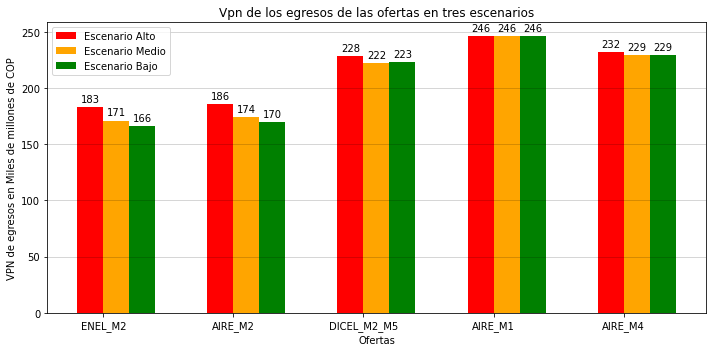

In [34]:
#*******************************************************************************
# # 5.6.3. Grafica de Vpn de las ofertas en tres escenarios (vertical).
# #*****************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = vpn_ofertas.index
escenario_alto = vpn_ofertas['Escenario Alto'].astype(int)
escenario_medio = vpn_ofertas['Escenario Medio'].astype(int)
escenario_bajo = vpn_ofertas['Escenario Bajo'].astype(int)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.bar(x - width/2, escenario_alto, width, label='Escenario Alto', \
    color='r')
rects2 = ax.bar(x + width/2, escenario_medio, width, label='Escenario Medio', \
    color='orange')
rects3 = ax.bar(x + 3 * width/2, escenario_bajo, width, label='Escenario Bajo', \
    color='g')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Vpn de los egresos de las ofertas en tres escenarios')
ax.set_xlabel('Ofertas')
ax.set_ylabel('VPN de egresos en Miles de millones de COP')
ax.set_xticks(x, ofertas)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.grid(axis='y', color='k', alpha=0.2)
plt.show()

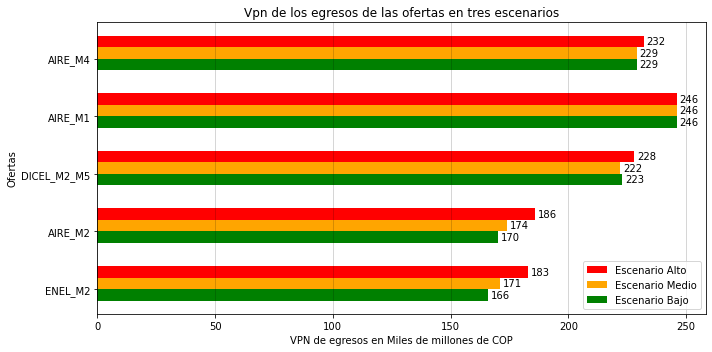

In [35]:
#*******************************************************************************
# 5.6.4. Grafica de Vpn de las ofertas en tres escenarios (horizontal).
#*******************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = vpn_ofertas.index
escenario_alto = vpn_ofertas['Escenario Alto'].astype(int)
escenario_medio = vpn_ofertas['Escenario Medio'].astype(int)
escenario_bajo = vpn_ofertas['Escenario Bajo'].astype(int)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.barh(x - width/2, escenario_bajo, width, label='Escenario Bajo', \
    color='g')
rects2 = ax.barh(x + width/2, escenario_medio, width, label='Escenario Medio', \
    color='orange')
rects3 = ax.barh(x + 3 * width/2, escenario_alto, width, label='Escenario Alto', \
    color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Vpn de los egresos de las ofertas en tres escenarios')
ax.set_xlabel('VPN de egresos en Miles de millones de COP')
ax.set_ylabel('Ofertas')
ax.set_yticks(x, ofertas)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

#obtiene los manejadores y etiquetas
handles, labels = plt.gca().get_legend_handles_labels()

#especific wl orden de los elementos en la leyenda
order = [2,1,0]

#agrega la leyenda al gráfico
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

fig.tight_layout()

plt.grid(axis='x', color='k', alpha=0.2)
plt.show()


In [36]:
#*******************************************************************************
# 5.6.5. Cálculo del Mínimo del Máximo arrepentimiento.
# *****************************************************************************
minimo = pd.DataFrame({'Escenario Alto': vpn_ofertas['Escenario Alto'].min(), \
    'Escenario Medio': vpn_ofertas['Escenario Medio'].min(), \
        'Escenario Bajo': vpn_ofertas['Escenario Bajo'].min()}, index=['Mínimo'])
minimo
arrepentimientos = pd.concat([vpn_ofertas, minimo])
arrepentimientos.insert(loc=len(arrepentimientos.columns), \
    column='arrepentimiento_alto', value=arrepentimientos['Escenario Alto'] - \
        arrepentimientos.loc['Mínimo', 'Escenario Alto'])
arrepentimientos.insert(loc=len(arrepentimientos.columns), \
    column='arrepentimiento_medio', value=arrepentimientos['Escenario Medio'] - \
        arrepentimientos.loc['Mínimo', 'Escenario Medio'])
arrepentimientos.insert(loc=len(arrepentimientos.columns), \
    column='arrepentimiento_bajo', value=arrepentimientos['Escenario Bajo'] - \
        arrepentimientos.loc['Mínimo', 'Escenario Bajo'])
arrepentimientos.insert(loc=len(arrepentimientos.columns), \
    column='maximo_arrepentimiento', 
    value=arrepentimientos.loc[:, ['arrepentimiento_alto', 'arrepentimiento_medio', 'arrepentimiento_bajo']].max(axis=1))
arrepentimientos

,Escenario Alto,Escenario Medio,Escenario Bajo,arrepentimiento_alto,arrepentimiento_medio,arrepentimiento_bajo,maximo_arrepentimiento
ENEL_M2,183.147740,171.057705,166.377889,0.000000,0.000000,0.000000,0.000000
AIRE_M2,186.796445,174.706409,170.026593,3.648704,3.648704,3.648704,3.648704
DICEL_M2_M5,228.057008,222.890235,223.082004,44.909267,51.832530,56.704115,56.704115
AIRE_M1,246.259224,246.259224,246.259224,63.111483,75.201519,79.881335,79.881335
AIRE_M4,232.410834,229.992827,229.992827,49.263094,58.935123,63.614938,63.614938
Mínimo,183.147740,171.057705,166.377889,0.000000,0.000000,0.000000,0.000000


In [37]:
#*******************************************************************************       
# 5.6.6. Guarda y lee arrepentimientos.
#*******************************************************************************
# # #Salva arrepentimientos
arrepentimientos.to_parquet('parquet/arrepentimientos.parquet.gzip', \
        compression='gzip', engine='fastparquet')
#Lee arrepentimientos
arrepentimientos = pd.read_parquet('parquet/arrepentimientos.parquet.gzip', engine='fastparquet')

In [38]:
#*******************************************************************************       
# 5.6.8. Quita la fila de Minimo.
#*******************************************************************************
arrepentimientos = arrepentimientos.drop(index='Mínimo', axis=0)

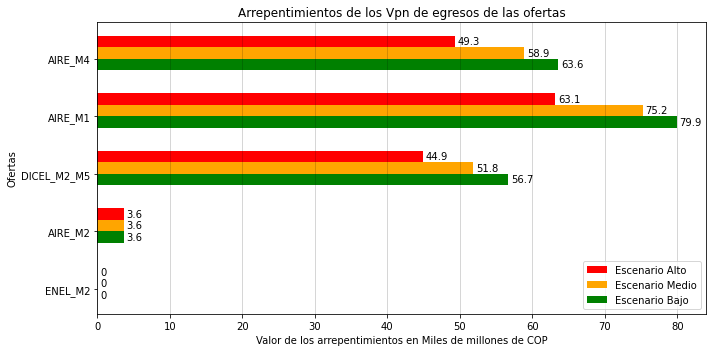

In [39]:
#*******************************************************************************
# 5.6.9. Grafica los arrepentimientos.
#*******************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = arrepentimientos.index
escenario_alto = arrepentimientos['arrepentimiento_alto'].round(1)
escenario_medio = arrepentimientos['arrepentimiento_medio'].round(1)
escenario_bajo = arrepentimientos['arrepentimiento_bajo'].round(1)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.barh(x - width/2, escenario_bajo, width, label='Escenario Bajo', \
    color='g')
rects2 = ax.barh(x + width/2, escenario_medio, width, label='Escenario Medio', \
    color='orange')
rects3 = ax.barh(x + 3 * width/2, escenario_alto, width, label='Escenario Alto', \
    color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Arrepentimientos de los Vpn de egresos de las ofertas')
ax.set_xlabel('Valor de los arrepentimientos en Miles de millones de COP')
ax.set_ylabel('Ofertas')
ax.set_yticks(x, ofertas)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

#obtiene los manejadores y etiquetas
handles, labels = plt.gca().get_legend_handles_labels()

#especific wl orden de los elementos en la leyenda
order = [2,1,0]

#agrega la leyenda al gráfico
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc=4) 

fig.tight_layout()

plt.grid(axis='x', color='k', alpha=0.2)
plt.show()


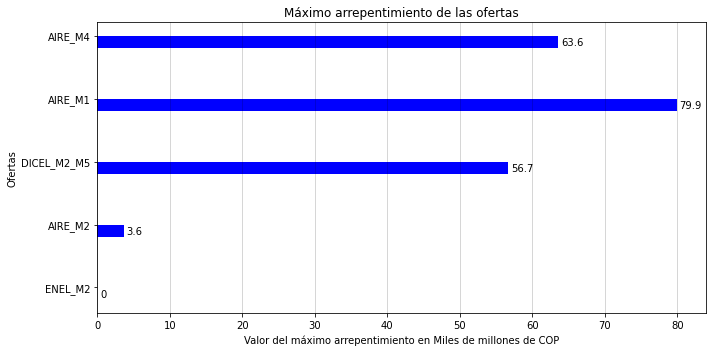

In [40]:
#*******************************************************************************
# 5.6.10. Grafica del máximo arrepentimiento de cada oferta.
#*******************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = arrepentimientos.index
escenario_alto = arrepentimientos['maximo_arrepentimiento'].round(1)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.barh(x - width/2, escenario_bajo, width, label='Escenario Bajo', \
    color='b')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Máximo arrepentimiento de las ofertas')
ax.set_xlabel('Valor del máximo arrepentimiento en Miles de millones de COP')
ax.set_ylabel('Ofertas')
ax.set_yticks(x, ofertas)

ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

# #obtiene los manejadores y etiquetas
# handles, labels = plt.gca().get_legend_handles_labels()

# #especific wl orden de los elementos en la leyenda
# order = [2,1,0]

# #agrega la leyenda al gráfico
# ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

fig.tight_layout()

plt.grid(axis='x', color='k', alpha=0.2)
plt.show()


## 5.7. Análisis de la oferta de EMSA_M2 en periodos P1 y P2
Se analizará la conveniencia de la oferta de EMSA en los periodos P1 y P2, al compararla con las otras ofertas en esos dos periodos.

In [41]:
#*******************************************************************************       
# 5.7.1. Lee vpn_ofertas_p1p2.
#*******************************************************************************
#Lee vpn_ofertas_p1p2
vpn_ofertas_p1p2 = pd.read_parquet('parquet/vpn_ofertas_p1p2.parquet.gzip', engine='fastparquet')

In [42]:
#*******************************************************************************       
# 5.7.2. Convierte el VPN a Miles de millones de pesos.
#*******************************************************************************
vpn_ofertas_p1p2 = vpn_ofertas_p1p2/1e3 #Miles de millones de pesos.

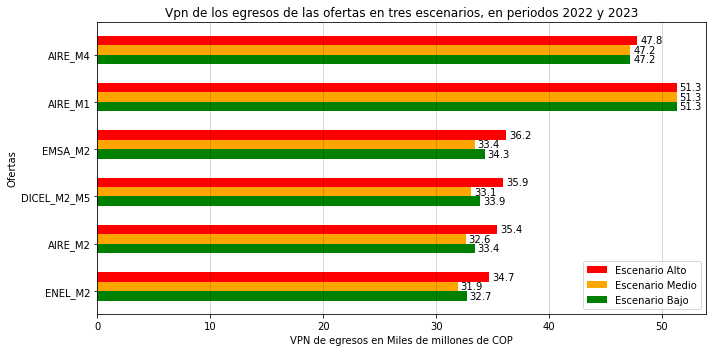

In [43]:
#*******************************************************************************
# 5.7.3. Grafica de Vpn de las ofertas en 2022 y 2023.
#*******************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = vpn_ofertas_p1p2.index
escenario_alto = vpn_ofertas_p1p2['Escenario Alto'].round(1)
escenario_medio = vpn_ofertas_p1p2['Escenario Medio'].round(1)
escenario_bajo = vpn_ofertas_p1p2['Escenario Bajo'].round(1)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.barh(x - width/2, escenario_bajo, width, label='Escenario Bajo', \
    color='g')
rects2 = ax.barh(x + width/2, escenario_medio, width, label='Escenario Medio', \
    color='orange')
rects3 = ax.barh(x + 3 * width/2, escenario_alto, width, label='Escenario Alto', \
    color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Vpn de los egresos de las ofertas en tres escenarios, en periodos 2022 y 2023')
ax.set_xlabel('VPN de egresos en Miles de millones de COP')
ax.set_ylabel('Ofertas')
ax.set_yticks(x, ofertas)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

#obtiene los manejadores y etiquetas
handles, labels = plt.gca().get_legend_handles_labels()

#especific wl orden de los elementos en la leyenda
order = [2,1,0]

#agrega la leyenda al gráfico
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

fig.tight_layout()

plt.grid(axis='x', color='k', alpha=0.2)
plt.show()


In [44]:
#*******************************************************************************
# 5.7.4. Cálculo del Mínimo del Máximo arrepentimiento en P1 y P2.
# *****************************************************************************
minimo = pd.DataFrame({'Escenario Alto': vpn_ofertas_p1p2['Escenario Alto'].min(), \
    'Escenario Medio': vpn_ofertas_p1p2['Escenario Medio'].min(), \
        'Escenario Bajo': vpn_ofertas_p1p2['Escenario Bajo'].min()}, index=['Mínimo'])

arrepentimientos_p1p2 = pd.concat([vpn_ofertas_p1p2, minimo])
arrepentimientos_p1p2.insert(loc=len(arrepentimientos_p1p2.columns), \
    column='arrepentimiento_alto', value=arrepentimientos_p1p2['Escenario Alto'] - \
        arrepentimientos_p1p2.loc['Mínimo', 'Escenario Alto'])
arrepentimientos_p1p2.insert(loc=len(arrepentimientos_p1p2.columns), \
    column='arrepentimiento_medio', value=arrepentimientos_p1p2['Escenario Medio'] - \
        arrepentimientos_p1p2.loc['Mínimo', 'Escenario Medio'])
arrepentimientos_p1p2.insert(loc=len(arrepentimientos_p1p2.columns), \
    column='arrepentimiento_bajo', value=arrepentimientos_p1p2['Escenario Bajo'] - \
        arrepentimientos_p1p2.loc['Mínimo', 'Escenario Bajo'])
arrepentimientos_p1p2.insert(loc=len(arrepentimientos_p1p2.columns), \
    column='maximo_arrepentimiento', 
    value=arrepentimientos_p1p2.loc[:, ['arrepentimiento_alto', 'arrepentimiento_medio', 'arrepentimiento_bajo']].max(axis=1))
arrepentimientos_p1p2

,Escenario Alto,Escenario Medio,Escenario Bajo,arrepentimiento_alto,arrepentimiento_medio,arrepentimiento_bajo,maximo_arrepentimiento
ENEL_M2,34.662366,31.894121,32.740228,0.000000,0.000000,0.000000,0.000000
AIRE_M2,35.355513,32.587268,33.433374,0.693146,0.693146,0.693146,0.693146
DICEL_M2_M5,35.862693,33.094448,33.940555,1.200327,1.200327,1.200327,1.200327
EMSA_M2,36.200813,33.432568,34.278675,1.538447,1.538447,1.538447,1.538447
AIRE_M1,51.341936,51.341936,51.341936,16.679570,19.447815,18.601708,19.447815
AIRE_M4,47.774727,47.221078,47.221078,13.112361,15.326957,14.480850,15.326957
Mínimo,34.662366,31.894121,32.740228,0.000000,0.000000,0.000000,0.000000


In [45]:
#*******************************************************************************       
# 5.7.5. Guarda y lee arrepentimientos_p1p2.
#*******************************************************************************
# # #Salva arrepentimientos
arrepentimientos_p1p2.to_parquet('parquet/arrepentimientos_p1p2.parquet.gzip', \
        compression='gzip', engine='fastparquet')
#Lee arrepentimientos
arrepentimientos_p1p2 = \
    pd.read_parquet('parquet/arrepentimientos_p1p2.parquet.gzip', \
        engine='fastparquet')

In [46]:
#*******************************************************************************       
# 5.7.6. Quita la fila de Minimo.
#*******************************************************************************
arrepentimientos_p1p2 = arrepentimientos_p1p2.drop(index='Mínimo', axis=0)

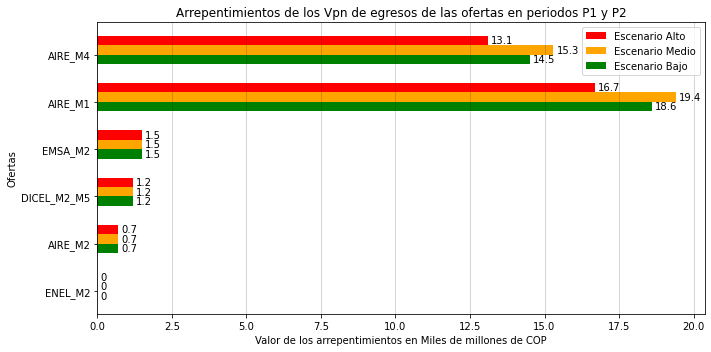

In [47]:
#*******************************************************************************
# 5.7.7. Grafica los arrepentimientos de los periodos P1 y P2.
#*******************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = arrepentimientos_p1p2.index
escenario_alto = arrepentimientos_p1p2['arrepentimiento_alto'].round(1)
escenario_medio = arrepentimientos_p1p2['arrepentimiento_medio'].round(1)
escenario_bajo = arrepentimientos_p1p2['arrepentimiento_bajo'].round(1)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.barh(x - width/2, escenario_bajo, width, label='Escenario Bajo', \
    color='g')
rects2 = ax.barh(x + width/2, escenario_medio, width, label='Escenario Medio', \
    color='orange')
rects3 = ax.barh(x + 3 * width/2, escenario_alto, width, label='Escenario Alto', \
    color='r')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Arrepentimientos de los Vpn de egresos de las ofertas en periodos P1 y P2')
ax.set_xlabel('Valor de los arrepentimientos en Miles de millones de COP')
ax.set_ylabel('Ofertas')
ax.set_yticks(x, ofertas)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

#obtiene los manejadores y etiquetas
handles, labels = plt.gca().get_legend_handles_labels()

#especific wl orden de los elementos en la leyenda
order = [2,1,0]

#agrega la leyenda al gráfico
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

fig.tight_layout()

plt.grid(axis='x', color='k', alpha=0.2)
plt.show()


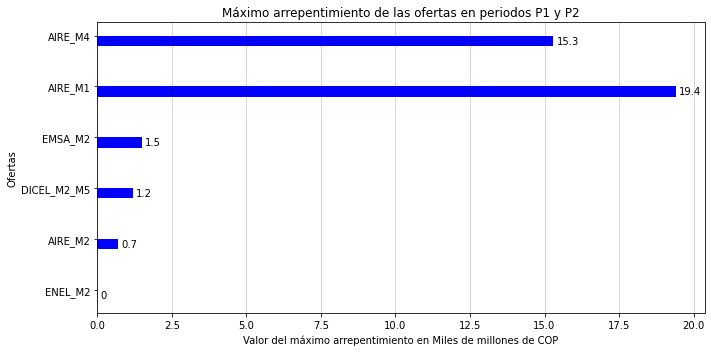

In [48]:
#*******************************************************************************
# 5.7.8. Grafica del máximo arrepentimiento de cada oferta.
#*******************************************************************************
fig, ax = plt.subplots(figsize=(10,5))

ofertas = arrepentimientos_p1p2.index
maximo_arrepentimiento = arrepentimientos_p1p2['maximo_arrepentimiento'].round(1)
 
x = np.arange(len(escenario_alto))  # the label locations
width = 0.20  # the width of the bars

rects1 = ax.barh(x - width/2, maximo_arrepentimiento, width, label='Máximo arrepentimiento', \
    color='b')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_title('Máximo arrepentimiento de las ofertas en periodos P1 y P2')
ax.set_xlabel('Valor del máximo arrepentimiento en Miles de millones de COP')
ax.set_ylabel('Ofertas')
ax.set_yticks(x, ofertas)

ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

# #obtiene los manejadores y etiquetas
# handles, labels = plt.gca().get_legend_handles_labels()

# #especific wl orden de los elementos en la leyenda
# order = [2,1,0]

# #agrega la leyenda al gráfico
# ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order]) 

fig.tight_layout()

plt.grid(axis='x', color='k', alpha=0.2)
plt.show()
